In [1]:
import torch, torchvision
import numpy as np
from matplotlib import pyplot as plt
from torch.utils.data.dataloader import DataLoader
from tqdm import tqdm

In [73]:
import logging
import pandas as pd
for handler in logging.root.handlers[:]:
    logging.root.removeHandler(handler)

logging.basicConfig(filename='lab2_train_log.csv', filemode='a', format='%(asctime)s,%(message)s', datefmt='%d-%m-%y %H:%M:%S', level=logging.INFO)

In [2]:
import cv2
import numpy as np
from torchvision.datasets import VOCSegmentation

cv2.setNumThreads(0)
cv2.ocl.setUseOpenCL(False)


VOC_CLASSES = [
    "background",
    "aeroplane",
    "bicycle",
    "bird",
    "boat",
    "bottle",
    "bus",
    "car",
    "cat",
    "chair",
    "cow",
    "diningtable",
    "dog",
    "horse",
    "motorbike",
    "person",
    "potted plant",
    "sheep",
    "sofa",
    "train",
    "tv/monitor",
]


VOC_COLORMAP = [
    [0, 0, 0],
    [128, 0, 0],
    [0, 128, 0],
    [128, 128, 0],
    [0, 0, 128],
    [128, 0, 128],
    [0, 128, 128],
    [128, 128, 128],
    [64, 0, 0],
    [192, 0, 0],
    [64, 128, 0],
    [192, 128, 0],
    [64, 0, 128],
    [192, 0, 128],
    [64, 128, 128],
    [192, 128, 128],
    [0, 64, 0],
    [128, 64, 0],
    [0, 192, 0],
    [128, 192, 0],
    [0, 64, 128],
]


class PascalVOCSearchDataset(VOCSegmentation):
    def __init__(self, root="~/data/pascal_voc", image_set="train", download=True, transform=None):
        super().__init__(root=root, image_set=image_set, download=download, transform=transform)

    @staticmethod
    def _convert_to_segmentation_mask(mask):
        # This function converts a mask from the Pascal VOC format to the format required by AutoAlbument.
        #
        # Pascal VOC uses an RGB image to encode the segmentation mask for that image. RGB values of a pixel
        # encode the pixel's class.
        #
        # AutoAlbument requires a segmentation mask to be a NumPy array with the shape [height, width, num_classes].
        # Each channel in this mask should encode values for a single class. Pixel in a mask channel should have
        # a value of 1.0 if the pixel of the image belongs to this class and 0.0 otherwise.
        height, width = mask.shape[:2]
        segmentation_mask = np.zeros((height, width, len(VOC_COLORMAP)), dtype=np.float32)
        for label_index, label in enumerate(VOC_COLORMAP):
            segmentation_mask[:, :, label_index] = np.all(mask == label, axis=-1).astype(float)
        return segmentation_mask

    def __getitem__(self, index):
        image = cv2.imread(self.images[index])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks[index])
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
        mask = self._convert_to_segmentation_mask(mask)
        if self.transform is not None:
            transformed = self.transform(image=image, mask=mask)
            image = transformed["image"]
            mask = transformed["mask"]
        image, mask = torchvision.transforms.functional.to_tensor(image), torch.from_numpy(mask)
        mask = mask.permute(2,0,1)
        return image, mask

Аугментация

In [3]:
from albumentations import Compose, RandomBrightnessContrast, RandomCrop, Flip, RandomSizedCrop, OneOf, PadIfNeeded, Resize

In [4]:
augs = Compose([
                 PadIfNeeded(448,448),
                 RandomBrightnessContrast(),
                 OneOf([
                        RandomCrop(256,256, p = 0.2),
                        RandomSizedCrop((224, 448), 256, 256)
                 ], p = 1)
])

augs_val = Compose([
    Resize(256, 256)
])

In [5]:
saving_path = "../Lab2/"
train_dataset = PascalVOCSearchDataset(saving_path, image_set="train", download = True, transform = augs)
test_dataset  = PascalVOCSearchDataset(saving_path, image_set="val",  download = True, transform = augs_val)

  0%|          | 0/1999639040 [00:00<?, ?it/s]

Extracting ../Lab2/VOCtrainval_11-May-2012.tar to ../Lab2/
Using downloaded and verified file: ../Lab2/VOCtrainval_11-May-2012.tar
Extracting ../Lab2/VOCtrainval_11-May-2012.tar to ../Lab2/


In [6]:
print("Train dataset shape :", train_dataset[0][1].shape)
print("Test dataset shape :", test_dataset[0][1].shape)

Train dataset shape : torch.Size([21, 256, 256])
Test dataset shape : torch.Size([21, 256, 256])


Функция отображения картинок

In [7]:
def show(i):
  img,lbl = i
  fig, ax = plt.subplots(1,2, sharey=True, figsize=(7,5))
  ax = ax.ravel()

  ax[0].imshow(img.permute(1,2,0))
  lbl_plot = ax[1].imshow(lbl.argmax(0),vmax = 19)
  plt.colorbar(lbl_plot, ax = ax[1])
  plt.show()

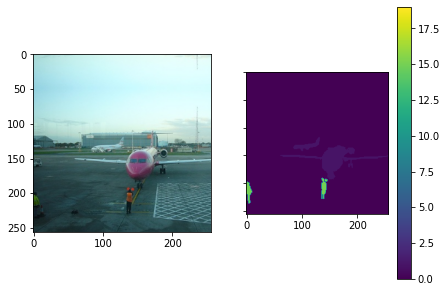

In [8]:
for i in range(1):
  show(train_dataset[i])

---

dataloaders + model + optim + crit

In [9]:
from torchvision.models.segmentation import deeplabv3_mobilenet_v3_large

In [10]:
train_dataloader = DataLoader(train_dataset, batch_size = 8, shuffle = True, num_workers = 2)
val_dataloader = DataLoader(test_dataset, batch_size = 8, shuffle = True, num_workers = 2)

In [11]:
model = deeplabv3_mobilenet_v3_large(True, num_classes = len(VOC_CLASSES), progress = True)
model.cuda()

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and will be removed in 0.15. Please use keyword parameter(s) instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=DeepLabV3_MobileNet_V3_Large_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_MobileNet_V3_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/deeplabv3_mobilenet_v3_large-fc3c493d.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_mobilenet_v3_large-fc3c493d.pth


  0%|          | 0.00/42.3M [00:00<?, ?B/s]

DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 64, kernel_size=(1, 1), stride

In [12]:
optim = torch.optim.AdamW(model.parameters(), lr = 3e-5, weight_decay = 1e-5)

In [13]:
crit = torch.nn.CrossEntropyLoss(label_smoothing = 1e-5)

---

IoU, MIoU

In [14]:
len(VOC_CLASSES)

21

In [15]:
def IoU(prediction, label):
  prediction = prediction.softmax(1)
  prediction = prediction.argmax(1)
  prediction = torch.nn.functional.one_hot(prediction, len(VOC_CLASSES))
  prediction = torch.transpose(prediction, 1, 3)
  prediction = torch.transpose(prediction, 2, 3)

  intersection  = torch.logical_and(label.to(int), prediction.to(int))
  intersection = intersection.sum([2, 3])
  union = torch.logical_or(label.to(int), prediction.to(int))
  union = union.count_nonzero([2, 3])
  return intersection / (union + 1e-6)


def MIoU(prediction, label):
  iou = IoU(prediction, label)
  return iou.sum(1) / (iou.count_nonzero(1) + 1e-6)

----

Обучение

In [16]:
DEBUG = False
EPOCHES = 5

h = {
    "train_loss": [],
    "val_loss": [],
    "val_miou": [],
    "epoches": list(range(1, EPOCHES + 1)),
}
train_n = len(train_dataloader)
val_n = len(val_dataloader)

for epoch in range(EPOCHES):
    train_s = "Training, epoch " + str(epoch + 1)
    train_loss_ep = 0

    cnt = 0
    model.train()
    for img, lbl in tqdm(train_dataloader, desc=train_s):
        img = img.cuda()
        lbl = lbl.cuda()
        p = model(img)["out"]
        loss = crit(p, lbl)
        loss.backward()
        optim.step()
        optim.zero_grad()
        train_loss_ep += loss.detach().cpu().item() / train_n
        if DEBUG and cnt > 10:
            break
        else:
            cnt += 1
    torch.cuda.empty_cache()

    val_s = "Validating, epoch " + str(epoch + 1)
    val_loss_ep = 0

    miou_ep = np.empty(shape=[0])
    cnt = 0
    model.eval()
    for img, lbl in tqdm(val_dataloader, desc=val_s):
        with torch.no_grad():
            img = img.cuda()
            lbl = lbl.cuda()
            p = model(img)["out"]
            loss = crit(p, lbl)
            val_loss_ep += loss.detach().cpu().item() / val_n
            miou_bc = MIoU(p, lbl).cpu().numpy()
            miou_ep = np.hstack((miou_ep, miou_bc))
            if DEBUG and cnt > 10:
                break
            else:
                cnt += 1
    torch.cuda.empty_cache()

    h["train_loss"].append(train_loss_ep)
    h["val_loss"].append(val_loss_ep)
    h["val_miou"].append(miou_ep.mean())


Validating, epoch 5: 100%|██████████| 182/182 [02:52<00:00,  1.06it/s]


Функция отображения картинок

In [112]:
def print_array(arr):
    fig, ax = plt.subplots(len(arr), 3, sharey=True, figsize=(3 * 3, len(arr) * 3))

    for i, elem in enumerate(arr):
        image = test_dataset[elem][0]
        label = test_dataset[elem][1]
        prediction = (
            model(image.clone().detach().reshape((1, 3, 256, 256)).cuda())["out"]
            .cpu()
            .softmax(1)[0]
        )
        ax[i, 0].imshow(image.permute(1, 2, 0))
        ax[i, 1].imshow(prediction.argmax(0), vmin=0, vmax = len(VOC_CLASSES)-1)
        ax[i, 2].imshow(label.argmax(0), vmin=0, vmax = len(VOC_CLASSES)-1)
    [ax.get_xaxis().set_visible(False) for ax in  fig.axes]
    [ax.get_yaxis().set_visible(False) for ax in fig.axes]
    fig.show()
    plt.show()

Графики метрик

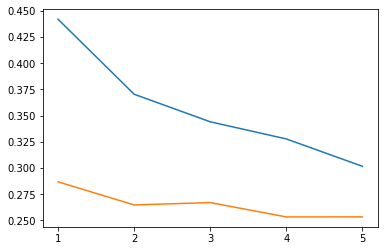

In [17]:
plt.plot(h["epoches"], h["train_loss"], label="Train CrossEntropyLoss")
plt.plot(h["epoches"], h["val_loss"], label="Validation CrossEntropyLoss")
plt.xticks(h["epoches"])
plt.show()


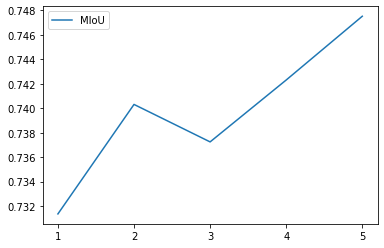

In [18]:
plt.plot(h["epoches"], h["val_miou"], label="MIoU")
plt.xticks(h["epoches"])
plt.legend()
plt.show()

In [19]:
DEBUG = False
EPOCHES = 50
epoch = 0

model.eval()

counter = np.zeros((len(VOC_CLASSES),)) 
iou_arr = np.zeros((len(VOC_CLASSES),))
iou_pairs = np.empty(shape=[0, len(VOC_CLASSES)])
iou_per_epoch = []

for (test_x, test_y) in tqdm(test_dataset):
    prediction = model(test_x.reshape((1, 3, 256, 256)).cuda())["out"]
    epoch_iou = IoU(prediction, test_y.cuda())[0].cpu().numpy()
    iou_pairs = np.vstack((iou_pairs, epoch_iou))

    y = np.unique(test_y.argmax(0))
    iou_per_epoch.append([-epoch_iou[y[1:]].mean(), epoch])

    counter[y] += 1
    iou_arr[y] += epoch_iou[y]

    if DEBUG and epoch > EPOCHES:
      break
    else:
      epoch += 1

100%|██████████| 1449/1449 [04:12<00:00,  5.73it/s]


In [20]:
best = iou_pairs.argmax(0)
iou_arr /= counter
res = []
iou_per_epoch_sorted = sorted(iou_per_epoch)
for iou, i in iou_per_epoch_sorted:
    res.append(i)

<ipython-input-21-860e8de4b336>:2: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax.set_xticks(range(len(VOC_CLASSES)), VOC_CLASSES)


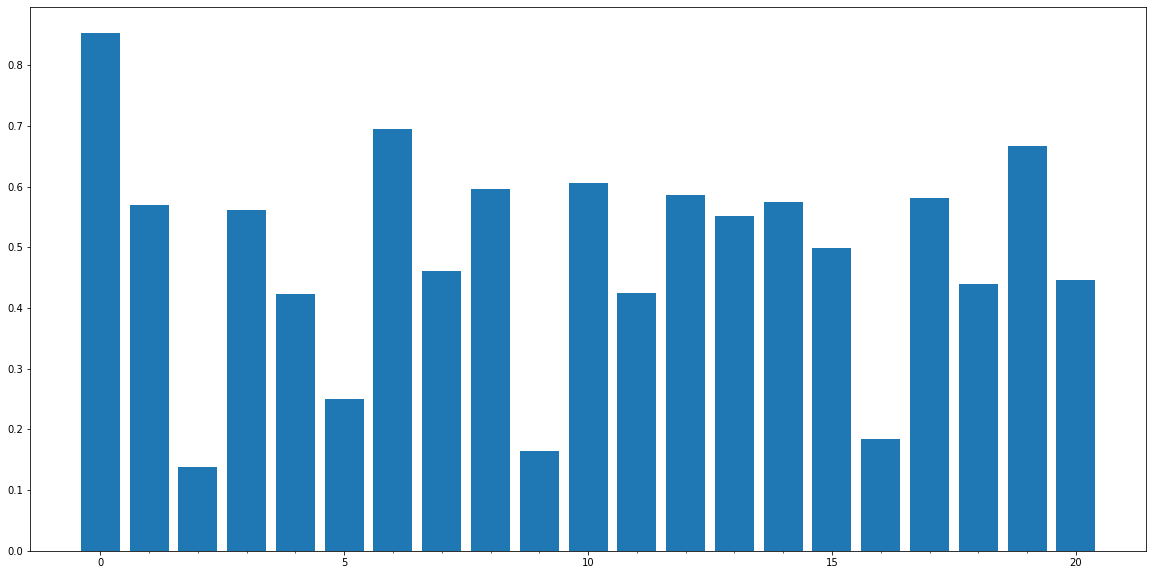

Values :  [0.85310056 0.56967145 0.13755082 0.5622228  0.42355204 0.25048386
 0.69586349 0.46168353 0.59635828 0.16368427 0.60684323 0.42450918
 0.58571091 0.55180997 0.57526355 0.49928283 0.18364691 0.5805915
 0.43970688 0.66734072 0.44667615]
Labels :  ['background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 'potted plant', 'sheep', 'sofa', 'train', 'tv/monitor']


In [21]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.set_xticks(range(len(VOC_CLASSES)), VOC_CLASSES)
plt.bar(range(len(VOC_CLASSES)), iou_arr)
plt.show()
print("Values : ", iou_arr)
print("Labels : ", VOC_CLASSES)

In [22]:
iou_per_epoch[0]

[-0.7597179, 0]

In [23]:
iou_per_epoch_sorted[0]

[-0.98818207, 1436]

---

Картинки по промежуткам

10 %

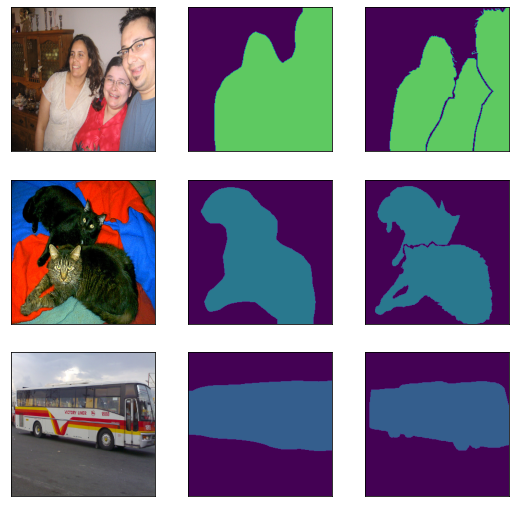

In [76]:
left = 0.0
right = 0.1
amount = 3
arr_10 = np.random.choice(res[int(left * len(res)) : int(right * len(res))], amount)
print_array(arr_10)

15% - 25%

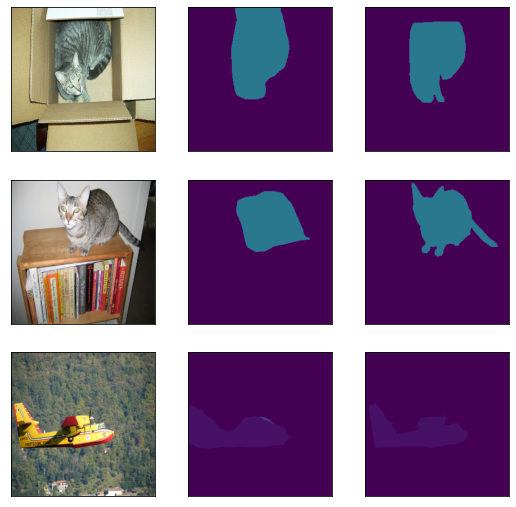

In [126]:
left = 0.15
right = 0.25
amount = 3
arr_15 = np.random.choice(res[int(left * len(res)) : int(right * len(res))], amount)
print_array(arr_15)

45% - 55%

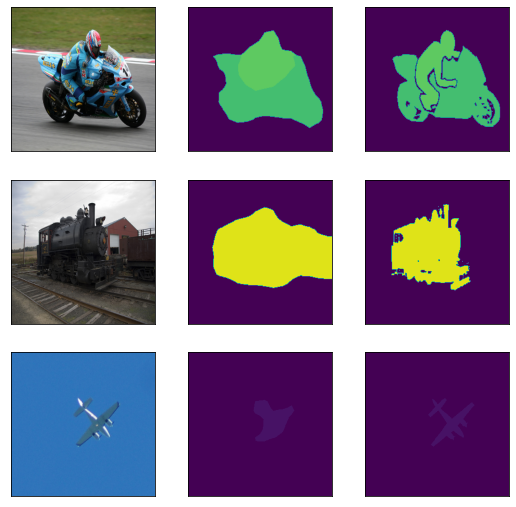

In [78]:
left = 0.45
right = 0.55
amount = 3
arr_45 = np.random.choice(res[int(left * len(res)) : int(right * len(res))], amount)
print_array(arr_45)

Лучшие по трем классам

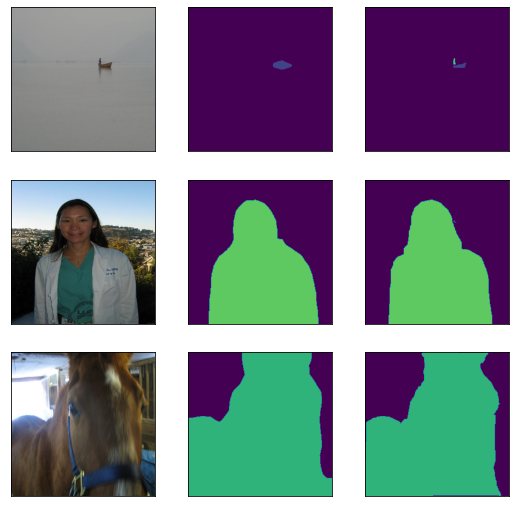

In [123]:
best_in_three = np.random.choice(np.arange(1, len(VOC_CLASSES)), 3, replace=False)
iou_pairs_max = iou_pairs.argmax(0)
iou_pairs_max.sort()
print_array([
    iou_pairs_max[best_in_three[0]],
    iou_pairs_max[best_in_three[1]],
    iou_pairs_max[best_in_three[2]]
])